In [1]:
import pandas as pd
from statsmodels.stats.contingency_tables import cochrans_q, mcnemar
import statsmodels.stats
import scipy.stats
import numpy as np
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'cmr10'
matplotlib.rcParams['font.size'] = 8

In [3]:
THRESHOLD = 0.05 #alpha significance level
PREDICTIONS_DIR = 'predictions'

NAMES = [
    'RU',
    'ST',
    'RO',
    'AD',
    'NO',
    'LA',]

tasks = {
    'binary': [0, 1], 
    'strat-binary': [0, 1],
    '4type': [0, 1, 2, 3],
    '5type': [0, 1, 2, 3, 4],
}
representations = ['bow', 'freq', 'tfidf']
models = ['decision-tree', 'svm', 'naive-bayes', 'xgboost']
methods = ['RandomUnder', 'SMOTETomek', 'RandomOver', 'ADASYN', 'none', 'aug']

In [4]:
#find the mode of a numpy array
def mode(array):
    freq = np.bincount(array)
    return np.argmax(freq)

In [5]:
def shorten_name(name):
    shortenings = {
    'decision-tree': 'dt',
    'naive-bayes-multinomial': 'nbm',
    'naive-bayes': 'nb',
    'xgboost': 'xgb',
    '-classification': '',
    '-type_of_antisemitism': '',}
    for long_version in shortenings:
        name = name.replace(long_version, shortenings[long_version])
    return name

#visualize the results of a post-hoc dunn analysis on a cochran's q test using matplotlib in a matrix
def visualize_dunn(dunn_values, names, out=False, title=None, evaluation=None):
    dunn_values = dunn_values.to_numpy()
    lower = np.tril(dunn_values, k=-1)
    dunn_values = np.ma.array(dunn_values, mask=lower)
    
    names = [shorten_name(name) for name in names]
    names = NAMES if out else names
    
    cmap = matplotlib.colormaps['viridis']
    cmap.set_bad('w')
    
    plt.matshow(dunn_values, cmap=cmap)
    ax = plt.gca()
    
    #remove border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    #remove tick marks
    ax.tick_params(axis=u'both', which=u'both',length=0)
    
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    rotation = 0 if out else 90
    ax.set_xticklabels(labels=names, rotation=rotation)
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_yticklabels(labels=names)
    
    for (i, j), z in np.ndenumerate(dunn_values):
        if out and j >= i:
            ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
        elif j >= i:
            ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    
    if out:
        fig = ax.get_figure()
        fig.savefig(f'{title}-{evaluation}.pdf', bbox_inches='tight', pad_inches = 0)
        
    plt.pause(0.1)

In [6]:
#find the raw accuracy scores of all of the columns
def find_accuracy(df):
    accuracies = [1,]
    for column in [column for column in df.columns.values if column != 'Actual']:
        df[column] = df.apply(lambda x: int(x[column] == x['Actual']), axis=1)
        accuracies.append(df[column].mean())
    return accuracies

In [7]:
#combine columns in a dataframe whose names contain certain substrings
def combine_columns(df, substrings):
    '''
    df: the input dataframe that has many column names that contain certain common substrings
    substrings: the list of substrings used for combination
    
    returns: `output_df`, a DataFrame with `substrings` as its columns. Each row is the mode
    of the value for that row of all of the columns in `df` that contained that substring.
    '''
    output_df = pd.DataFrame()
    
    for column_substring in substrings:
        temp_df = pd.DataFrame()
        to_be_combined = [column for column in df.columns.values if column_substring in column]
        
        for column in to_be_combined:
            temp_df[column] = df[column]
            
        array = np.array(temp_df).astype(int)
        array = [mode(row) for row in array]
            
        output_df[column_substring] = array
    
    return output_df

In [8]:
#find which models performed best using different eval metrics
def evaluate_models(df, substrings, evaluation, answer):
    output_df = pd.DataFrame()
    combined_df = combine_columns(df, substrings)
    for column in substrings:
        temp_combined_df = combined_df.copy() if evaluation == 'recall' else combined_df[combined_df[column] == answer].copy()
        comparison_df = df if evaluation == 'recall' else df[df[column] == answer]
        temp_combined_df[column] = temp_combined_df[column] == comparison_df['Actual']
        output_df[column] = [None,] if len(temp_combined_df) == 0 else [sum(temp_combined_df[column])/len(temp_combined_df),]
    output_df.index = ['Score']
    if 'index' in output_df.columns.values: del output_df['index']
    return output_df

#test model significance difference w/ Friedman Chi^2 while combining certain columns
def test_model_difference(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    cochran_result = cochrans_q(columns)
    return cochran_result

def post_hoc_tests(df, substrings):
    df = combine_columns(df, substrings)
    columns = [df[substring] for substring in substrings]
    p_values = sp.posthoc_dunn(columns)
    return p_values

In [9]:
def print_result(task, cochran_result, post_hoc_p, df, score_df, method):
    print(f'Task: {task}.')
    print(f'Method: {method}')
    print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
    if cochran_result.pvalue <= THRESHOLD:
        print('Post-hoc Dunn test array:')
        visualize_dunn(post_hoc_p, df.columns.values)
    
    score_df.index = [shorten_name(name) for name in score_df.index]
    print(score_df)
    print(f'\nMean: {score_df["Mean score"].mean()}')
    print('\n\n')

In [10]:
#get a list of binary dfs of whether or not they fit with a particular classification
def get_dfs(df, classifications, evaluation):
    if evaluation == 'precision': return [df,] * len(classifications)
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    return dfs

def get_mean(series):
    mean = np.mean(series)
    mean -= 1/len(series.dropna())
    mean /= len(series.dropna())
    mean *= len(series.dropna()-1)
    return mean

#find specific rankings for each model
def overall_evaluation(task, classifications, method, evaluation):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    score_df = pd.DataFrame()
    dfs = get_dfs(df, classifications, evaluation)
        
    for (i, temp_df) in enumerate(dfs):
        temp_df = evaluate_models(temp_df, temp_df.columns.values, evaluation, i).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
            
        score_df[f'Score {i}'] = temp_df['Score']
    
    score_df['Mean score'] = score_df.mean(axis=1)
    score_df['Accuracy'] = find_accuracy(df)
    score_df = score_df.sort_values('Mean score', ascending = False)
    indeces = list(score_df.index)
    score_df.loc[len(score_df)] = score_df.apply(get_mean, axis=0)
    indeces.append('Mean')
    score_df.index = indeces
    cochran_result = cochrans_q(df)
    post_hoc_p = pd.DataFrame()
    if cochran_result.pvalue <= THRESHOLD:
        post_hoc_p = post_hoc_tests(df, df.columns.values)
    
    print_result(task, cochran_result, post_hoc_p, df, score_df, method)
    
    return score_df.drop(index=['Actual', 'Mean'])

In [11]:
def evaluate_rep_model(grouping, dfs):
    final_df = pd.DataFrame()
    
    for i, df in enumerate(dfs):
        temp_df = evaluate_models(df, grouping).transpose()
        temp_df = temp_df.sort_values('Score', ascending=False)
        
        temp_df.columns = ['Score']
        final_df[f'Score {i}'] = temp_df['Score']
        
    return final_df

#evaluate algorithms and representations, find significance level
def algorithm_and_rep_eval(task, classifications, method):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    dfs = []
    for classification in classifications:
        temp_df = df[df['Actual'] == classification]
        temp_df = temp_df.reset_index()
        dfs.append(temp_df)
    for grouping in [representations, models]:
        score_df = evaluate_rep_model(grouping, dfs)
        score_df['Mean score'] = score_df.mean(axis=1)
        score_df = score_df.sort_values('Mean score', ascending = False)
        indeces = list(score_df.index)
        score_df.loc[len(score_df)] = score_df.apply(get_mean, axis=0)
        indeces.append('Mean')
        score_df.index = indeces
        
        combined_df = combine_columns(df, grouping)
        cochran_result = cochrans_q(combined_df)
        if cochran_result.pvalue <= THRESHOLD:
            post_hoc_p = post_hoc_tests(combined_df, grouping)
        '''
        print(f'Task: {task}. Grouping: {grouping}.')
        print(f"Cochran's Q test p-value: {cochran_result.pvalue}")
        if cochran_result.pvalue <= THRESHOLD:
            print('Post-hoc Dunn test array:')
            visualize_dunn(post_hoc_p, grouping)
        
        score_df.index = [shorten_name(name) for name in score_df.index]
        print(f"Scores: \n{score_df}")
        print(f'\nMean: {score_df["Mean score"].mean()}')
        print('\n\n')
        '''

In [12]:
#evaluate the overall resampling methods, perform friedman test and post-hoc nemenyi
def evaluate_resampling(overall_df, indeces, title, evaluation):
    columns = [overall_df[column] for column in overall_df.columns.values]
    statistic, pvalue = scipy.stats.friedmanchisquare(*columns)
    #if 'Mean' not in indeces:
    overall_df.loc[len(overall_df)] = overall_df.apply(lambda x: np.mean(x))
    indeces.append('Mean')
    overall_df.index = indeces
    print('\nOverall scores:')
    print(f'Friedman Chi Square Statistic: {statistic}. p-value: {pvalue}.')
    print(overall_df)
    if pvalue <= THRESHOLD:
        overall_df = overall_df.transpose()
        columns = [overall_df[column] for column in overall_df.columns.values]
        p_values = sp.posthoc_nemenyi_friedman(columns)
        print('\nPost-hoc Nemenyi test array:')
        visualize_dunn(p_values, list(overall_df.index), out=True, title=title, evaluation=evaluation)

The below visualizations and `DataFrame`s contain testing information on the various algorithms and representation methods used to create models. Data is shown on two tasks, 'binary,' referring to the binary classification of whether or not a particular tweet is antisemitic, and 'type,' referring to classifying the tweet with a particular type of antisemitism. The model evaluation was done in two stages, first the overall evaluation, then the grouped evaluation for different algorithms and representations. Some names are shortened during presentation: `decision-tree` is shortened to `dt`, `naive-bayes-multinomial` to `nbm`, and `naive-bayes` to `nb`.

For the overall evaluation, the model scores were generated using the arithmetic mean of the recalls on each individual class, with a Cochran's Q test being performed on a matrix that contained columns for each model and in each column contained a `1` where the model found the correct answer, and `0` where the model found the incorrect answer. Then, if the Q test found an *p*-value lower than the specified global `THRESHOLD` constant, it performs a post-hoc Dunn text, which is then visualized in the form of a matrix, with higher values meaning lighter colors and a greater correlation between two models' answers. Then, the score `DataFrame` is shown, with a column entitled `Mean score` for the arithmetic mean of the recall of the model on each class. There are additional columns entitles `Score {x}`, with `{x}` being the specific class that that column gives the recall of for each model. Finally, an overall mean of the `Mean score` column is given.

For the model grouping evaluation, models are grouped into classes either by their representation or algorithm type. The most common answer across all models of this type is then taken as the answer for this grouping. Following this, the same process as above was used.

In [13]:
def get_f1_df(precision_df, recall_df):
    return 2 * (precision_df * recall_df) / (precision_df + recall_df).replace(0, float('NaN'))

def evaluate_f1(task, method, score_df):
    df = pd.read_csv(f'{PREDICTIONS_DIR}\\{task}_predictions-{method}.csv')
    cochran_result = cochrans_q(df)
    post_hoc_p = post_hoc_tests(df, df.columns.values)
    print_result(task, cochran_result, post_hoc_p, df, score_df, method)

def task_eval(task):
    print(f'\n\nTask: {task.title()}\n\n')
    evaluation_dict = dict()
    for evaluation in ['recall', 'precision']:
        evaluation_dict[evaluation] = []
        print(f'{evaluation.title()}\n')
        overall_df = pd.DataFrame()
        indeces = []
        for method in methods:
            print(f'\nMethod: {method}\n')
            temp_df = overall_evaluation(task, tasks[task], method, evaluation) #find the rankings for all models
            evaluation_dict[evaluation].append(temp_df)
            if not indeces:
                indeces = list(temp_df.index)
            overall_df[method] = temp_df['Mean score']
            #algorithm_and_rep_eval(task, tasks[task], method) #group representations and algorithms together, evaluate
        evaluate_resampling(overall_df, indeces, task, evaluation)
    
    print('\n\nF1\n\n')
    f1_dfs = [get_f1_df(evaluation_dict['precision'][i], evaluation_dict['recall'][i]) for i in range(len(evaluation_dict['recall']))]
    f1_overall = pd.DataFrame()
    for (i, method) in enumerate(methods):
            indeces = list(f1_dfs[i].index)
            f1_dfs[i].loc[len(f1_dfs[i])] = [1.0,] * len(f1_dfs[i].columns.values)
            indeces.append('Actual')
            f1_dfs[i].loc[len(f1_dfs[i])] = f1_dfs[i].apply(get_mean, axis=0)
            indeces.append('Mean')
            f1_dfs[i].index = indeces
            
            evaluate_f1(task, method, f1_dfs[i])
            f1_dfs[i] = f1_dfs[i].drop(index=['Actual', 'Mean'])
            
            f1_overall[method] = f1_dfs[i]['Mean score']
            indeces = list(f1_dfs[i].index)
    evaluate_resampling(f1_overall, indeces, task, 'f1')



Task: Binary


Recall


Method: RandomUnder

Task: binary.
Method: RandomUnder
Cochran's Q test p-value: 3.833920609579536e-270
Post-hoc Dunn test array:


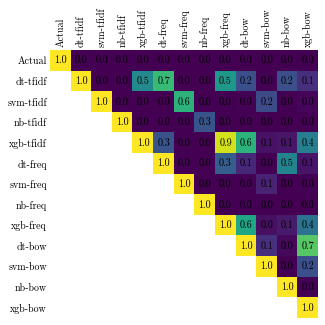

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.721461  0.645349    0.683405  0.502459
xgb-bow    0.689498  0.645349    0.667423  0.639344
svm-freq   0.827626  0.491279    0.659452  0.647541
svm-tfidf  0.816210  0.488372    0.652291  0.723770
xgb-freq   0.681507  0.604651    0.643079  0.659836
xgb-tfidf  0.686073  0.598837    0.642455  0.732787
dt-bow     0.707763  0.575581    0.641672  0.661475
nb-bow     0.616438  0.645349    0.630894  0.700000
dt-tfidf   0.682648  0.558140    0.620394  0.524590
dt-freq    0.675799  0.546512    0.611155  0.670492
nb-freq    0.450913  0.712209    0.581561  0.624590
nb-tfidf   0.442922  0.654070    0.548496  0.677049
Mean       0.615297  0.551208    0.583252  0.597226

Mean: 0.6546807299634633




Method: SMOTETomek

Task: binary.
Method: SMOTETomek
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


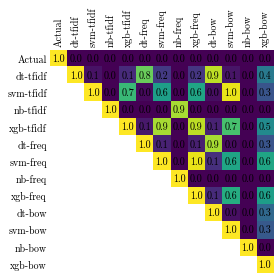

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.794521  0.543605    0.669063  0.680328
svm-tfidf  0.809361  0.508721    0.659041  0.686066
xgb-bow    0.762557  0.549419    0.655988  0.713934
svm-freq   0.791096  0.514535    0.652815  0.713115
xgb-freq   0.799087  0.497093    0.648090  0.426230
xgb-tfidf  0.804795  0.491279    0.648037  0.724590
dt-bow     0.748858  0.517442    0.633150  0.683607
dt-freq    0.778539  0.430233    0.604386  0.429508
dt-tfidf   0.795662  0.406977    0.601319  0.716393
nb-bow     0.463470  0.639535    0.551503  0.723770
nb-freq    0.285388  0.796512    0.540950  0.702459
nb-tfidf   0.285388  0.784884    0.535136  0.513115
Mean       0.624517  0.513864    0.569191  0.593317

Mean: 0.6406191106334465




Method: RandomOver

Task: binary.
Method: RandomOver
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


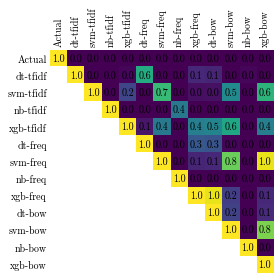

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.773973  0.590116    0.682044  0.727869
xgb-bow    0.796804  0.549419    0.673111  0.421311
svm-tfidf  0.825342  0.508721    0.667032  0.664754
svm-freq   0.813927  0.508721    0.661324  0.736066
xgb-tfidf  0.791096  0.508721    0.649908  0.711475
dt-bow     0.764840  0.523256    0.644048  0.696721
nb-bow     0.585616  0.694767    0.640192  0.722131
xgb-freq   0.781963  0.476744    0.629354  0.674590
dt-freq    0.771689  0.427326    0.599508  0.437705
dt-tfidf   0.764840  0.409884    0.587362  0.695902
nb-freq    0.296804  0.796512    0.546658  0.616393
nb-tfidf   0.277397  0.787791    0.532594  0.727049
Mean       0.634176  0.521691    0.577933  0.602459

Mean: 0.6493619937989162




Method: ADASYN

Task: binary.
Method: ADASYN
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


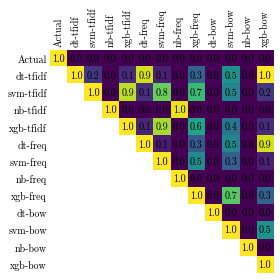

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-tfidf  0.736301  0.590116    0.663209  0.700820
svm-freq   0.753425  0.566860    0.660143  0.665574
svm-bow    0.711187  0.601744    0.656466  0.413115
xgb-bow    0.694064  0.598837    0.646451  0.686885
xgb-freq   0.757991  0.505814    0.631902  0.697541
xgb-tfidf  0.783105  0.479651    0.631378  0.667213
dt-bow     0.639269  0.563953    0.601611  0.618033
dt-tfidf   0.775114  0.392442    0.583778  0.413934
dt-freq    0.776256  0.383721    0.579988  0.695082
nb-bow     0.449772  0.630814    0.540293  0.680328
nb-tfidf   0.267123  0.787791    0.527457  0.500820
nb-freq    0.265982  0.787791    0.526886  0.667213
Mean       0.585353  0.529964    0.557659  0.569735

Mean: 0.629087183921526




Method: none

Task: binary.
Method: none
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


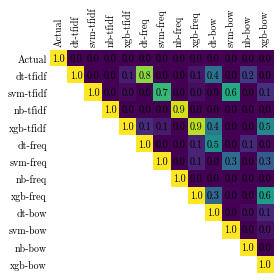

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.918950  0.415698    0.667324  0.474590
xgb-bow    0.864155  0.418605    0.641380  0.759016
nb-bow     0.704338  0.563953    0.634146  0.777049
svm-tfidf  0.940639  0.325581    0.633110  0.767213
dt-bow     0.816210  0.433140    0.624675  0.708197
xgb-freq   0.864155  0.377907    0.621031  0.695082
xgb-tfidf  0.865297  0.366279    0.615788  0.724590
svm-freq   0.949772  0.273256    0.611514  0.690984
dt-freq    0.819635  0.377907    0.598771  0.472951
dt-tfidf   0.817352  0.369186    0.593269  0.727049
nb-tfidf   0.361872  0.761628    0.561750  0.664754
nb-freq    0.359589  0.761628    0.560608  0.738525
Mean       0.713997  0.418828    0.566413  0.630769

Mean: 0.6378412988201138




Method: aug

Task: binary.
Method: aug
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


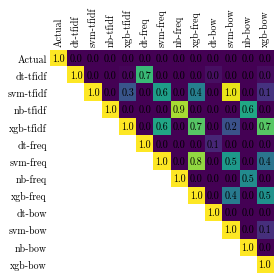

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.785388  0.572674    0.679031  0.645082
xgb-bow    0.727169  0.616279    0.671724  0.713115
svm-tfidf  0.812785  0.500000    0.656393  0.724590
xgb-freq   0.794521  0.491279    0.642900  0.459836
xgb-tfidf  0.787671  0.485465    0.636568  0.702459
svm-freq   0.821918  0.436047    0.628982  0.653279
dt-tfidf   0.716895  0.491279    0.604087  0.709016
dt-freq    0.723744  0.444767    0.584256  0.456557
dt-bow     0.651826  0.514535    0.583181  0.613115
nb-tfidf   0.309361  0.843023    0.576192  0.470492
nb-freq    0.304795  0.843023    0.573909  0.695902
nb-bow     0.345890  0.787791    0.566841  0.725410
Mean       0.598613  0.540474    0.569543  0.582219

Mean: 0.6409718891600065




Overall scores:
Friedman Chi Square Statistic: 18.52380952380952. p-value: 0.002356742395759757.
           RandomUnder  SMOTETomek  RandomOver    ADASYN      none       aug
svm-bow       0.

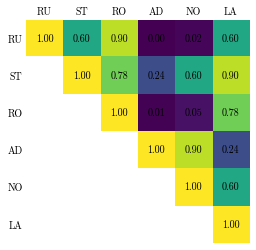

Precision


Method: RandomUnder

Task: binary.
Method: RandomUnder
Cochran's Q test p-value: 3.833920609579536e-270
Post-hoc Dunn test array:


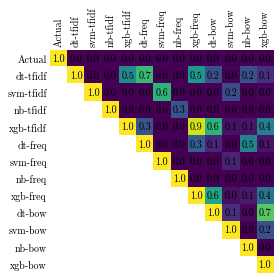

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-freq   0.805556  0.528125    0.666840  0.524590
svm-bow    0.838196  0.476395    0.657296  0.647541
svm-tfidf  0.802469  0.510638    0.656554  0.659836
xgb-bow    0.831956  0.449393    0.640674  0.723770
dt-bow     0.809399  0.436123    0.622761  0.732787
xgb-freq   0.814461  0.427105    0.620783  0.661475
xgb-tfidf  0.813261  0.428274    0.620768  0.639344
nb-bow     0.815710  0.397849    0.606780  0.502459
dt-tfidf   0.797333  0.408511    0.602922  0.700000
dt-freq    0.791444  0.398305    0.594874  0.624590
nb-freq    0.799595  0.337466    0.568530  0.670492
nb-tfidf   0.765286  0.315568    0.540427  0.677049
Mean       0.744974  0.393366    0.569170  0.597226

Mean: 0.640598536195989




Method: SMOTETomek

Task: binary.
Method: SMOTETomek
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


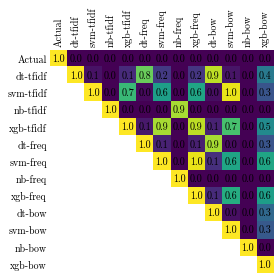

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.815944  0.509537    0.662740  0.686066
svm-tfidf  0.807517  0.511696    0.659606  0.426230
xgb-tfidf  0.801136  0.497059    0.649098  0.713115
svm-freq   0.805814  0.491667    0.648740  0.716393
xgb-freq   0.801833  0.492795    0.647314  0.680328
xgb-bow    0.811665  0.476071    0.643868  0.724590
dt-bow     0.798054  0.447236    0.622645  0.429508
dt-tfidf   0.773585  0.438871    0.606228  0.723770
dt-freq    0.776765  0.432749    0.604757  0.683607
nb-freq    0.781250  0.304444    0.542847  0.713934
nb-bow     0.766038  0.318841    0.542439  0.702459
nb-tfidf   0.771605  0.301339    0.536472  0.513115
Mean       0.731631  0.401716    0.566673  0.593317

Mean: 0.6381020182254259




Method: RandomOver

Task: binary.
Method: RandomOver
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


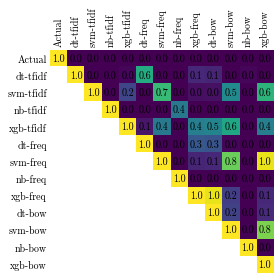

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-tfidf  0.810538  0.533537    0.672037  0.711475
svm-bow    0.827839  0.506234    0.667037  0.736066
xgb-bow    0.818288  0.514986    0.666637  0.421311
svm-freq   0.808390  0.517751    0.663071  0.674590
xgb-tfidf  0.803944  0.488827    0.646386  0.727869
dt-bow     0.803357  0.466321    0.634839  0.437705
xgb-freq   0.791908  0.461972    0.626940  0.695902
nb-bow     0.830097  0.397010    0.613554  0.664754
dt-freq    0.774341  0.423631    0.598986  0.722131
dt-tfidf   0.767468  0.406340    0.586904  0.727049
nb-freq    0.787879  0.307865    0.547872  0.696721
nb-tfidf   0.768987  0.299779    0.534383  0.616393
Mean       0.737926  0.409558    0.573742  0.602459

Mean: 0.6451705481978861




Method: ADASYN

Task: binary.
Method: ADASYN
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


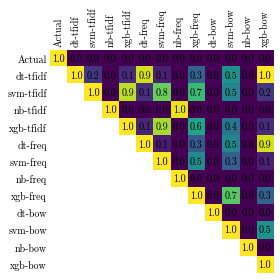

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-freq   0.815822  0.474453    0.645137  0.413934
svm-tfidf  0.820611  0.467742    0.644176  0.667213
svm-bow    0.819737  0.450000    0.634868  0.695082
xgb-tfidf  0.793064  0.464789    0.628926  0.700820
xgb-bow    0.815013  0.434599    0.624806  0.697541
xgb-freq   0.796163  0.450777    0.623470  0.665574
dt-tfidf   0.764640  0.406627    0.585633  0.686885
dt-bow     0.788732  0.380392    0.584562  0.413115
dt-freq    0.762332  0.402439    0.582385  0.618033
nb-bow     0.756238  0.310443    0.533341  0.667213
nb-tfidf   0.762215  0.296824    0.529519  0.680328
nb-freq    0.761438  0.296499    0.528968  0.500820
Mean       0.727385  0.371968    0.549676  0.569735

Mean: 0.6211050207121972




Method: none

Task: binary.
Method: none
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


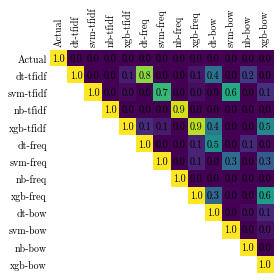

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.800199  0.668224    0.734212  0.767213
svm-tfidf  0.780303  0.682927    0.731615  0.472951
svm-freq   0.768946  0.681159    0.725053  0.664754
xgb-bow    0.791014  0.547529    0.669271  0.695082
xgb-freq   0.779609  0.522088    0.650849  0.727049
xgb-tfidf  0.776639  0.516393    0.646516  0.708197
dt-bow     0.785714  0.480645    0.633180  0.759016
nb-bow     0.804433  0.428256    0.616344  0.690984
dt-freq    0.770386  0.451389    0.610888  0.777049
dt-tfidf   0.767417  0.442509    0.604963  0.738525
nb-tfidf   0.794486  0.319123    0.556805  0.474590
nb-freq    0.793451  0.318348    0.555899  0.724590
Mean       0.724046  0.466045    0.595046  0.630769

Mean: 0.6664742435189067




Method: aug

Task: binary.
Method: aug
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


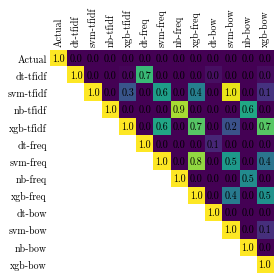

            Score 0   Score 1  Mean score  Accuracy
Actual     1.000000  1.000000    1.000000  1.000000
svm-bow    0.823952  0.511688    0.667820  0.702459
svm-tfidf  0.805430  0.511905    0.658667  0.713115
xgb-bow    0.828349  0.470067    0.649208  0.459836
xgb-freq   0.799082  0.484241    0.641661  0.456557
svm-freq   0.787746  0.490196    0.638971  0.613115
xgb-tfidf  0.795848  0.473088    0.634468  0.709016
dt-tfidf   0.782067  0.405276    0.593672  0.725410
nb-tfidf   0.833846  0.324022    0.578934  0.653279
dt-freq    0.768485  0.387342    0.577913  0.695902
nb-freq    0.831776  0.322581    0.577178  0.724590
dt-bow     0.773713  0.367220    0.570466  0.470492
nb-bow     0.805851  0.321090    0.563471  0.645082
Mean       0.741242  0.389901    0.565571  0.582219

Mean: 0.637000045982841




Overall scores:
Friedman Chi Square Statistic: 30.095238095238074. p-value: 1.4125434752708043e-05.
           RandomUnder  SMOTETomek  RandomOver    ADASYN      none       aug
svm-freq      

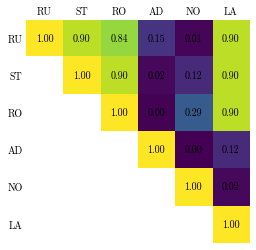



F1


Task: binary.
Method: RandomUnder
Cochran's Q test p-value: 2.871787033070148e-215
Post-hoc Dunn test array:


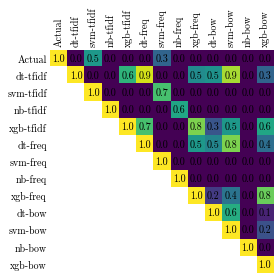

            Score 0   Score 1  Mean score  Accuracy
dt-bow     0.755177  0.496241    0.632075  0.695307
dt-freq    0.729064  0.460784    0.602905  0.646728
dt-tfidf   0.735547  0.471744    0.611533  0.599732
nb-bow     0.702211  0.492239    0.618602  0.585003
nb-freq    0.576642  0.457944    0.574972  0.646728
nb-tfidf   0.561099  0.425733    0.544432  0.677049
svm-bow    0.775460  0.548148    0.670096  0.565848
svm-freq   0.816441  0.509036    0.663126  0.579617
svm-tfidf  0.809281  0.499257    0.654415  0.690326
xgb-bow    0.754057  0.529833    0.653775  0.678943
xgb-freq   0.742076  0.500602    0.631734  0.660655
xgb-tfidf  0.744272  0.499394    0.631425  0.682884
Actual     1.000000  1.000000    1.000000  1.000000
Mean       0.669333  0.453150    0.576084  0.592986

Mean: 0.6475124963410263



Task: binary.
Method: SMOTETomek
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


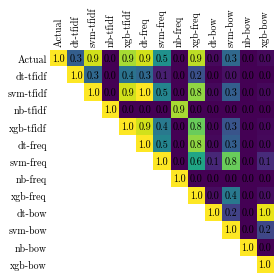

            Score 0   Score 1  Mean score  Accuracy
dt-bow     0.772674  0.479784    0.627854  0.527555
dt-freq    0.777651  0.431487    0.604571  0.527555
dt-tfidf   0.784468  0.422323    0.603764  0.720063
nb-bow     0.577525  0.425532    0.546933  0.712956
nb-freq    0.418060  0.440514    0.541897  0.708150
nb-tfidf   0.416667  0.435484    0.535803  0.513115
svm-bow    0.805090  0.526020    0.665886  0.683185
svm-freq   0.798387  0.502841    0.650771  0.714750
svm-tfidf  0.808438  0.510204    0.659324  0.525798
xgb-bow    0.786345  0.510121    0.649871  0.719223
xgb-freq   0.800457  0.494935    0.647702  0.524104
xgb-tfidf  0.802961  0.494152    0.648567  0.718807
Actual     1.000000  1.000000    1.000000  1.000000
Mean       0.657594  0.436415    0.567919  0.584251

Mean: 0.639347280212479



Task: binary.
Method: RandomOver
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


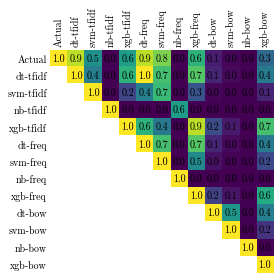

            Score 0   Score 1  Mean score  Accuracy
dt-bow     0.783626  0.493151    0.639410  0.537643
dt-freq    0.773013  0.425470    0.599247  0.545043
dt-tfidf   0.766152  0.408104    0.587133  0.711135
nb-bow     0.686747  0.505285    0.626590  0.692256
nb-freq    0.431177  0.444084    0.547264  0.654100
nb-tfidf   0.407718  0.434295    0.533487  0.667164
svm-bow    0.800000  0.544966    0.674457  0.731944
svm-freq   0.811149  0.513196    0.662196  0.703988
svm-tfidf  0.817873  0.520833    0.669525  0.687322
xgb-bow    0.807403  0.531646    0.669859  0.421311
xgb-freq   0.786904  0.469242    0.628144  0.685080
xgb-tfidf  0.797468  0.498575    0.648142  0.719579
Actual     1.000000  1.000000    1.000000  1.000000
Mean       0.666864  0.445296    0.575804  0.596659

Mean: 0.6472327897329812



Task: binary.
Method: ADASYN
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


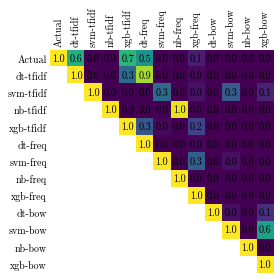

            Score 0   Score 1  Mean score  Accuracy
dt-bow     0.706179  0.454333    0.592964  0.495212
dt-freq    0.769231  0.392857    0.581184  0.654297
dt-tfidf   0.769841  0.399408    0.584704  0.516570
nb-bow     0.564066  0.416107    0.536794  0.673707
nb-freq    0.394247  0.430843    0.527925  0.572165
nb-tfidf   0.395604  0.431185    0.528486  0.576933
svm-bow    0.761614  0.514925    0.645486  0.518227
svm-freq   0.783383  0.516556    0.652554  0.510425
svm-tfidf  0.776173  0.521851    0.653554  0.683604
xgb-bow    0.749692  0.503667    0.635444  0.692172
xgb-freq   0.776608  0.476712    0.627658  0.681183
xgb-tfidf  0.788053  0.472103    0.630150  0.683604
Actual     1.000000  1.000000    1.000000  1.000000
Mean       0.633438  0.425427    0.553608  0.558315

Mean: 0.6250366105757524



Task: binary.
Method: none
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


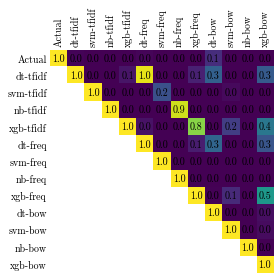

            Score 0   Score 1  Mean score  Accuracy
dt-bow     0.800672  0.455657    0.628899  0.732726
dt-freq    0.794248  0.411392    0.604769  0.588010
dt-tfidf   0.791598  0.402536    0.599059  0.732742
nb-bow     0.751065  0.486826    0.625118  0.731494
nb-freq    0.494894  0.449015    0.558244  0.731491
nb-tfidf   0.497255  0.449785    0.559266  0.553802
svm-bow    0.855473  0.512545    0.699172  0.586424
svm-freq   0.849847  0.390041    0.663461  0.677615
svm-tfidf  0.853002  0.440945    0.678808  0.585171
xgb-bow    0.825968  0.474465    0.655029  0.725644
xgb-freq   0.819708  0.438449    0.635590  0.710706
xgb-tfidf  0.818575  0.428571    0.630778  0.716300
Actual     1.000000  1.000000    1.000000  1.000000
Mean       0.704023  0.410787    0.579861  0.620933

Mean: 0.6512894689114619



Task: binary.
Method: aug
Cochran's Q test p-value: 0.0
Post-hoc Dunn test array:


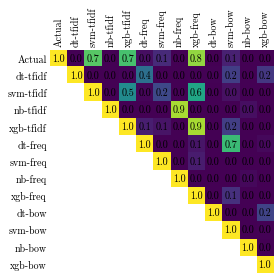

            Score 0   Score 1  Mean score  Accuracy
dt-bow     0.707559  0.428571    0.576753  0.532417
dt-freq    0.745444  0.414073    0.581067  0.551376
dt-tfidf   0.748064  0.444152    0.598834  0.717119
nb-bow     0.484026  0.456229    0.565151  0.682892
nb-freq    0.446115  0.466613    0.575539  0.709956
nb-tfidf   0.451291  0.468119    0.577560  0.547020
svm-bow    0.804208  0.540466    0.673379  0.672549
svm-freq   0.804469  0.461538    0.633937  0.632560
svm-tfidf  0.809091  0.505882    0.657528  0.718807
xgb-bow    0.774468  0.533333    0.660274  0.559130
xgb-freq   0.796795  0.487734    0.642280  0.458191
xgb-tfidf  0.791738  0.479197    0.635516  0.705722
Actual     1.000000  1.000000    1.000000  1.000000
Mean       0.643328  0.437378    0.567524  0.575980

Mean: 0.6389530605839598




Overall scores:
Friedman Chi Square Statistic: 22.52380952380952. p-value: 0.0004161725948319398.
           RandomUnder  SMOTETomek  RandomOver    ADASYN      none       aug
dt-bow        0

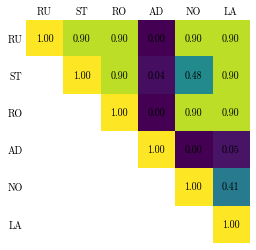

In [14]:
task_eval('binary')



Task: 5Type


Recall


Method: RandomUnder

Task: 5type.
Method: RandomUnder
Cochran's Q test p-value: 1.467281451377e-311
Post-hoc Dunn test array:


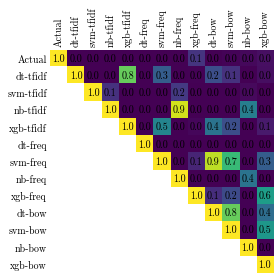

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
dt-bow     0.424658  0.364706  0.375000  0.333333  0.201613    0.339862   
dt-tfidf   0.457763  0.341176  0.250000  0.285714  0.250000    0.316931   
svm-bow    0.410959  0.447059  0.125000  0.380952  0.129032    0.298600   
xgb-bow    0.394977  0.423529  0.125000  0.333333  0.169355    0.289239   
nb-freq    0.234018  0.452941  0.000000  0.452381  0.225806    0.273029   
xgb-tfidf  0.482877  0.176471  0.125000  0.333333  0.233871    0.270310   
dt-freq    0.546804  0.352941  0.000000  0.166667  0.266129    0.266508   
svm-tfidf  0.228311  0.382353  0.250000  0.309524  0.129032    0.259844   
svm-freq   0.449772  0.252941  0.000000  0.214286  0.266129    0.236626   
xgb-freq   0.396119  0.300000  0.000000  0.214286  0.266129    0.235307   
nb-tfidf   0.271689  0.335294  0.125000  0.238095  0.201613    0.234338   
nb-bow     0.277397  0.43

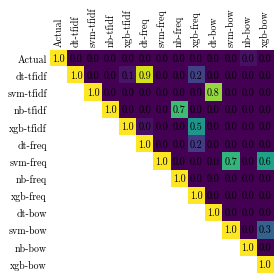

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
svm-freq   0.549087  0.458824  0.000000  0.404762  0.225806    0.327696   
xgb-tfidf  0.752283  0.358824  0.000000  0.214286  0.193548    0.303788   
xgb-freq   0.740868  0.329412  0.000000  0.214286  0.185484    0.294010   
svm-tfidf  0.448630  0.435294  0.000000  0.309524  0.233871    0.285464   
dt-bow     0.454338  0.435294  0.000000  0.238095  0.258065    0.277158   
xgb-bow    0.545662  0.458824  0.000000  0.142857  0.225806    0.274630   
nb-bow     0.305936  0.358824  0.125000  0.380952  0.201613    0.274465   
dt-freq    0.712329  0.288235  0.000000  0.190476  0.177419    0.273692   
nb-tfidf   0.140411  0.364706  0.250000  0.380952  0.201613    0.267536   
nb-freq    0.159817  0.323529  0.250000  0.404762  0.193548    0.266331   
svm-bow    0.586758  0.423529  0.000000  0.095238  0.201613    0.261428   
dt-tfidf   0.727169  0.26

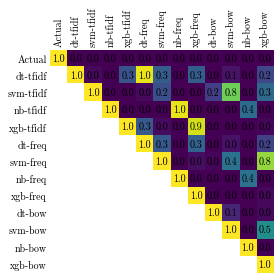

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
xgb-bow    0.640411  0.382353  0.375000  0.309524  0.129032    0.367264   
svm-freq   0.627854  0.476471  0.000000  0.380952  0.129032    0.322862   
svm-tfidf  0.598174  0.382353  0.000000  0.404762  0.225806    0.322219   
svm-bow    0.625571  0.388235  0.250000  0.214286  0.129032    0.321425   
dt-bow     0.579909  0.341176  0.250000  0.238095  0.185484    0.318933   
nb-bow     0.079909  0.294118  0.375000  0.547619  0.241935    0.307716   
xgb-freq   0.712329  0.358824  0.000000  0.095238  0.209677    0.275214   
xgb-tfidf  0.719178  0.335294  0.000000  0.119048  0.201613    0.275027   
dt-freq    0.692922  0.323529  0.000000  0.142857  0.177419    0.267346   
nb-freq    0.116438  0.294118  0.250000  0.452381  0.201613    0.262910   
dt-tfidf   0.697489  0.294118  0.000000  0.119048  0.185484    0.259228   
nb-tfidf   0.117580  0.32

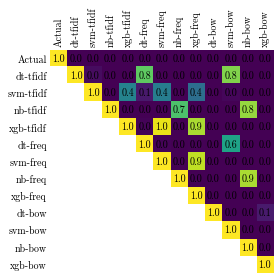

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
nb-bow     0.089041  0.311765  0.125000  0.785714  0.266129    0.315530   
svm-freq   0.924658  0.182353  0.250000  0.000000  0.000000    0.271402   
svm-tfidf  0.899543  0.158824  0.250000  0.000000  0.048387    0.271351   
nb-tfidf   0.117580  0.347059  0.250000  0.404762  0.177419    0.259364   
nb-freq    0.115297  0.294118  0.250000  0.428571  0.185484    0.254694   
xgb-freq   0.901826  0.276471  0.000000  0.000000  0.072581    0.250176   
xgb-tfidf  0.897260  0.276471  0.000000  0.000000  0.072581    0.249262   
dt-freq    0.824201  0.241176  0.000000  0.023810  0.104839    0.238805   
dt-tfidf   0.817352  0.241176  0.000000  0.023810  0.088710    0.234209   
svm-bow    0.803653  0.335294  0.000000  0.000000  0.016129    0.231015   
xgb-bow    0.729452  0.258824  0.000000  0.071429  0.032258    0.218392   
dt-bow     0.672374  0.26

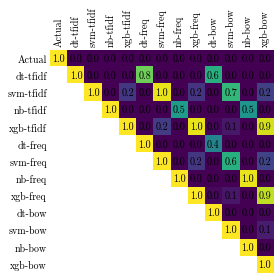

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
nb-bow     0.090183  0.305882  0.375000  0.547619  0.241935    0.312124   
dt-bow     0.817352  0.376471  0.000000  0.142857  0.080645    0.283465   
svm-bow    0.942922  0.435294  0.000000  0.000000  0.008065    0.277256   
xgb-bow    0.896119  0.388235  0.000000  0.047619  0.032258    0.272846   
xgb-tfidf  0.901826  0.311765  0.000000  0.000000  0.096774    0.262073   
svm-tfidf  0.948630  0.317647  0.000000  0.000000  0.040323    0.261320   
nb-tfidf   0.118721  0.352941  0.250000  0.404762  0.161290    0.257543   
xgb-freq   0.905251  0.300000  0.000000  0.000000  0.080645    0.257179   
dt-tfidf   0.824201  0.270588  0.000000  0.023810  0.120968    0.247913   
nb-freq    0.115297  0.270588  0.250000  0.428571  0.169355    0.246762   
svm-freq   0.962329  0.270588  0.000000  0.000000  0.000000    0.246583   
dt-freq    0.817352  0.27

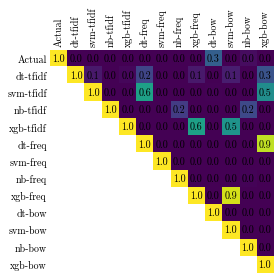

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
dt-freq    0.460046  0.370588  0.500000  0.404762  0.274194    0.401918   
dt-bow     0.367580  0.341176  0.500000  0.452381  0.298387    0.391905   
xgb-freq   0.536530  0.405882  0.250000  0.404762  0.314516    0.382338   
svm-bow    0.512557  0.500000  0.125000  0.333333  0.370968    0.368372   
dt-tfidf   0.500000  0.364706  0.375000  0.309524  0.290323    0.367910   
nb-bow     0.262557  0.370588  0.375000  0.357143  0.411290    0.355316   
xgb-tfidf  0.567352  0.317647  0.125000  0.404762  0.338710    0.350694   
svm-freq   0.644977  0.400000  0.000000  0.309524  0.314516    0.333803   
xgb-bow    0.456621  0.382353  0.125000  0.357143  0.346774    0.333578   
svm-tfidf  0.460046  0.288235  0.125000  0.452381  0.282258    0.321584   
nb-tfidf   0.251142  0.370588  0.125000  0.452381  0.233871    0.286596   
nb-freq    0.231735  0.31

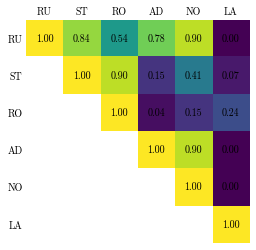

Precision


Method: RandomUnder

Task: 5type.
Method: RandomUnder
Cochran's Q test p-value: 1.467281451377e-311
Post-hoc Dunn test array:


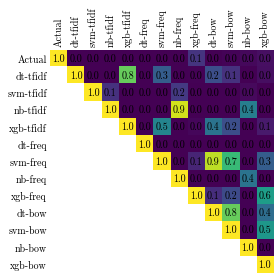

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
dt-bow     0.865116  0.308458  0.014286  0.069307  0.141243    0.279682   
dt-tfidf   0.813387  0.316940  0.013699  0.052863  0.181287    0.275635   
svm-bow    0.859189  0.317992  0.005952  0.074074  0.089888    0.269419   
dt-freq    0.805042  0.266667  0.000000  0.059829  0.206250    0.267558   
xgb-tfidf  0.816602  0.267857  0.005376  0.057377  0.181250    0.265693   
xgb-bow    0.843902  0.300000  0.006173  0.069652  0.101449    0.264235   
svm-freq   0.789579  0.333333  0.000000  0.047120  0.107492    0.255505   
xgb-freq   0.808858  0.219828  0.000000  0.069767  0.151376    0.249966   
nb-bow     0.820946  0.241042  0.000000  0.042857  0.110599    0.243089   
nb-freq    0.776515  0.212121  0.000000  0.066202  0.146597    0.240287   
svm-tfidf  0.704225  0.194611  0.008230  0.044068  0.250000    0.240227   
nb-tfidf   0.760383  0.22

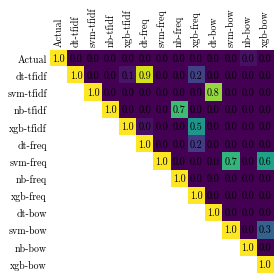

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
svm-tfidf  0.806982  0.468354  0.000000  0.034667  0.213235    0.304648   
svm-freq   0.800333  0.390000  0.000000  0.072034  0.183007    0.289075   
xgb-tfidf  0.800729  0.344633  0.000000  0.115385  0.184615    0.289072   
xgb-freq   0.799261  0.352201  0.000000  0.095745  0.161972    0.281836   
xgb-bow    0.775974  0.346667  0.000000  0.081081  0.160920    0.272928   
svm-bow    0.766021  0.344498  0.000000  0.058824  0.173611    0.268591   
dt-bow     0.781925  0.313559  0.000000  0.086207  0.150943    0.266527   
dt-freq    0.777086  0.284884  0.000000  0.081633  0.162963    0.261313   
nb-freq    0.813953  0.284974  0.004535  0.082927  0.114833    0.260244   
nb-tfidf   0.803922  0.287037  0.004556  0.080402  0.117371    0.258657   
dt-tfidf   0.771186  0.258621  0.000000  0.070000  0.150943    0.250150   
nb-bow     0.748603  0.26

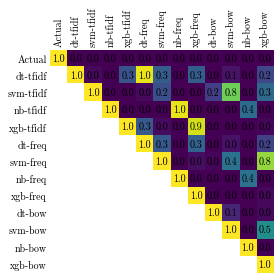

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
svm-tfidf  0.829114  0.403727  0.000000  0.074236  0.229508    0.307317   
svm-freq   0.819672  0.405000  0.000000  0.103226  0.133333    0.292246   
xgb-bow    0.811867  0.298165  0.032609  0.119266  0.145455    0.281472   
xgb-tfidf  0.789474  0.343373  0.000000  0.076923  0.174825    0.276919   
xgb-freq   0.788875  0.344633  0.000000  0.060606  0.189781    0.276779   
svm-bow    0.809453  0.323529  0.022989  0.084112  0.110345    0.270086   
dt-bow     0.810207  0.272300  0.020619  0.077519  0.149351    0.265999   
dt-freq    0.793464  0.273632  0.000000  0.098361  0.157143    0.264520   
nb-bow     0.864198  0.231481  0.008086  0.074919  0.122449    0.260227   
dt-tfidf   0.790427  0.261780  0.000000  0.084746  0.156463    0.258683   
nb-freq    0.784615  0.246305  0.004505  0.087963  0.110132    0.246704   
nb-tfidf   0.780303  0.25

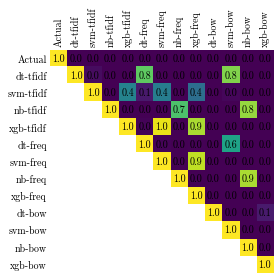

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000       1.0  1.000000    1.000000   
svm-bow    0.760259  0.483051  0.000000      None  0.500000    0.435828   
svm-tfidf  0.776355  0.385714  0.017857      None  0.260870    0.360199   
svm-freq   0.773639  0.469697  0.020202      None  0.000000    0.315884   
xgb-bow    0.759810  0.360656  0.000000       0.3  0.078431    0.299779   
xgb-freq   0.772994  0.415929  0.000000       0.0  0.155172    0.268819   
xgb-tfidf  0.775148  0.405172  0.000000       0.0  0.140625    0.264189   
nb-bow     0.876404  0.237668  0.005291  0.071584  0.127907    0.263771   
dt-bow     0.753197  0.340909  0.000000  0.096774  0.100000    0.258176   
dt-freq    0.762408  0.292857  0.000000  0.032258  0.162500    0.250005   
nb-tfidf   0.786260  0.266968  0.004545  0.077982  0.104762    0.248103   
nb-freq    0.782946  0.247525  0.004566  0.081081  0.100437    0.243311   
dt-tfidf   0.764141  0.28

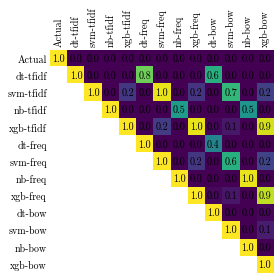

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000       1.0       1.0  1.000000    1.000000   
svm-bow    0.783681  0.453988      None      None  0.333333    0.523667   
svm-tfidf  0.770872  0.446281      None      None  0.238095    0.485083   
svm-freq   0.757412  0.464646      None      None  0.000000    0.407353   
xgb-bow    0.787362  0.404908       0.0  0.222222  0.081633    0.299225   
dt-bow     0.783370  0.357542       0.0  0.146341  0.129870    0.283425   
xgb-tfidf  0.774510  0.449153       0.0       0.0  0.181818    0.281096   
xgb-freq   0.772152  0.425000       0.0       0.0  0.163934    0.272217   
nb-bow     0.877778  0.238532  0.008086  0.074919  0.128205    0.265504   
dt-tfidf   0.768085  0.319444       0.0  0.033333  0.150000    0.254173   
dt-freq    0.770721  0.298701       0.0  0.029412  0.145833    0.248934   
nb-tfidf   0.787879  0.270270  0.004505  0.077982  0.098039    0.247735   
nb-freq    0.782946  0.23

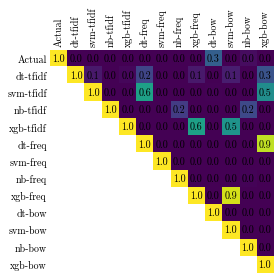

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
Actual     1.000000  1.000000  1.000000  1.000000  1.000000    1.000000   
svm-bow    0.837687  0.304659  0.055556  0.155556  0.154882    0.301668   
svm-freq   0.801418  0.311927  0.000000  0.164557  0.183099    0.292200   
xgb-freq   0.802048  0.273810  0.033333  0.146552  0.189320    0.289013   
xgb-tfidf  0.808130  0.257143  0.023256  0.134921  0.185841    0.281858   
xgb-bow    0.829876  0.210356  0.016949  0.145631  0.161049    0.272772   
dt-freq    0.809237  0.226619  0.053333  0.126866  0.144681    0.272147   
svm-tfidf  0.787109  0.270718  0.034483  0.057402  0.209581    0.271859   
dt-tfidf   0.780749  0.255144  0.066667  0.093525  0.155172    0.270251   
nb-bow     0.798611  0.217993  0.013514  0.109489  0.179577    0.263837   
dt-bow     0.805000  0.192691  0.041237  0.121795  0.139098    0.259964   
nb-tfidf   0.753425  0.211409  0.004000  0.102703  0.148718    0.244051   
nb-freq    0.727599  0.19

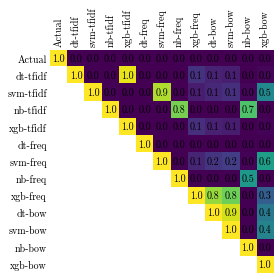

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
dt-bow     0.569678  0.334232  0.027523  0.114754  0.166113    0.306849   
dt-freq    0.651258  0.303797       NaN  0.088050  0.232394    0.267032   
dt-tfidf   0.585829  0.328612  0.025974  0.089219  0.210169    0.294844   
nb-bow     0.414676  0.310273       NaN  0.071429  0.140762    0.233211   
nb-freq    0.359649  0.288931       NaN  0.115502  0.177778    0.255614   
nb-tfidf   0.400336  0.272727  0.012048  0.053191  0.171821    0.234788   
svm-bow    0.555985  0.371638  0.011364  0.124031  0.105960    0.283260   
svm-freq   0.573091  0.287625       NaN  0.077253  0.153132    0.245703   
svm-tfidf  0.344828  0.257937  0.015936  0.077151  0.170213    0.249651   
xgb-bow    0.538103  0.351220  0.011765  0.115226  0.126888    0.276172   
xgb-freq   0.531801  0.253731       NaN  0.105263  0.192982    0.242415   
xgb-tfidf  0.606887  0.212766  0.010309  0.097902  0.204225    0.267982   
Actual     1.000000  1.00

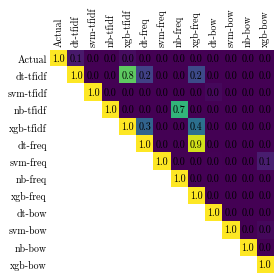

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
dt-bow     0.574729  0.364532       NaN  0.126582  0.190476    0.271739   
dt-freq    0.743300  0.286550       NaN  0.114286  0.169884    0.267359   
dt-tfidf   0.748531  0.261628       NaN  0.098592  0.139130    0.253779   
nb-bow     0.434360  0.307305  0.010152  0.106312  0.160772    0.258122   
nb-freq    0.267176  0.303030  0.008909  0.137652  0.144144    0.263253   
nb-tfidf   0.239067  0.321244  0.008949  0.132780  0.148368    0.263022   
svm-bow    0.664512  0.379947       NaN  0.072727  0.186567    0.264961   
svm-freq   0.651320  0.421622       NaN  0.122302  0.202166    0.307176   
svm-tfidf  0.576669  0.451220       NaN  0.062350  0.223077    0.294744   
xgb-bow    0.640751  0.394937       NaN  0.103448  0.187919    0.273776   
xgb-freq   0.768957  0.340426       NaN  0.132353  0.172932    0.287794   
xgb-tfidf  0.775750  0.351585       NaN  0.150000  0.188976    0.296248   
Actual     1.000000  1.00

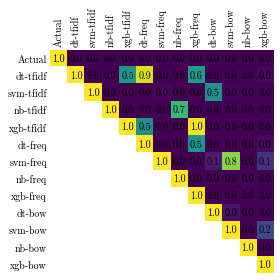

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
dt-bow     0.675981  0.302872  0.038095  0.116959  0.165468    0.290071   
dt-freq    0.739793  0.296496       NaN  0.116505  0.166667    0.265925   
dt-tfidf   0.741055  0.277008       NaN  0.099010  0.169742    0.258955   
nb-bow     0.146290  0.259067  0.015831  0.131805  0.162602    0.281986   
nb-freq    0.202783  0.268097  0.008850  0.147287  0.142450    0.254549   
nb-tfidf   0.204365  0.284974  0.008869  0.133858  0.129032    0.249321   
svm-bow    0.705731  0.352941  0.042105  0.120805  0.118959    0.293527   
svm-freq   0.711054  0.437838       NaN  0.162437  0.131148    0.306792   
svm-tfidf  0.694960  0.392749       NaN  0.125461  0.227642    0.314592   
xgb-bow    0.716018  0.335052  0.060000  0.172185  0.136752    0.318695   
xgb-freq   0.748650  0.351585       NaN  0.074074  0.199234    0.275994   
xgb-tfidf  0.752688  0.339286       NaN  0.093458  0.187266    0.275970   
Actual     1.000000  1.00

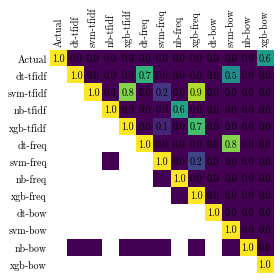

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
dt-bow     0.710495  0.298013       NaN  0.082192  0.078431    0.234383   
dt-freq    0.792101  0.264516       NaN  0.027397  0.127451    0.244277   
dt-tfidf   0.789851  0.260317       NaN  0.027778  0.103774    0.237579   
nb-bow     0.161658  0.269720  0.010152  0.131213  0.172775    0.287338   
nb-freq    0.200995  0.268817  0.008969  0.136364  0.130312    0.248872   
nb-tfidf   0.204568  0.301790  0.008929  0.130769  0.131737    0.253609   
svm-bow    0.781354  0.395833       NaN       NaN  0.031250    0.301969   
svm-freq   0.842434  0.262712  0.037383       NaN       NaN    0.291959   
svm-tfidf  0.833421  0.225000  0.033333       NaN  0.081633    0.309525   
xgb-bow    0.744321  0.301370       NaN  0.115385  0.045714    0.252694   
xgb-freq   0.832455  0.332155       NaN       NaN  0.098901    0.259162   
xgb-tfidf  0.831746  0.328671       NaN       NaN  0.095745    0.256509   
Actual     1.000000  1.00

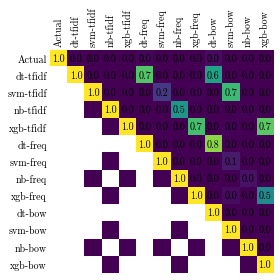

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
dt-bow     0.800000  0.366762       NaN  0.144578  0.099502    0.283445   
dt-freq    0.793352  0.283951       NaN  0.026316  0.127273    0.246916   
dt-tfidf   0.795154  0.292994       NaN  0.027778  0.133929    0.251004   
nb-bow     0.163561  0.268041  0.015831  0.131805  0.167598    0.286933   
nb-freq    0.200995  0.250000   0.00885  0.137405  0.118980    0.242643   
nb-tfidf   0.206349  0.306122   0.00885  0.130769  0.121951    0.252544   
svm-bow    0.855959  0.444444       NaN       NaN  0.015748    0.362557   
svm-freq   0.847662  0.342007       NaN       NaN       NaN    0.307206   
svm-tfidf  0.850563  0.371134       NaN       NaN  0.068966    0.339661   
xgb-bow    0.838227  0.396396       NaN  0.078431  0.046243    0.285427   
xgb-freq   0.833421  0.351724       NaN       NaN  0.108108    0.264485   
xgb-tfidf  0.833333  0.368056       NaN       NaN  0.126316    0.271251   
Actual     1.000000  1.00

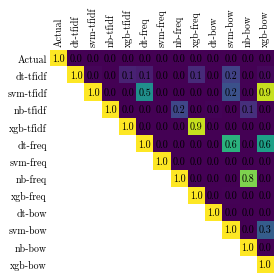

            Score 0   Score 1   Score 2   Score 3   Score 4  Mean score  \
dt-bow     0.504702  0.246285  0.076190  0.191919  0.189744    0.312582   
dt-freq    0.586608  0.281250  0.096386  0.193182  0.189415    0.324541   
dt-tfidf   0.609603  0.300242  0.113208  0.143646  0.202247    0.311608   
nb-bow     0.395189  0.274510  0.026087  0.167598  0.250000    0.302818   
nb-freq    0.351515  0.237136  0.014925  0.132075  0.150838    0.244930   
nb-tfidf   0.376712  0.269231  0.007752  0.167401  0.181818    0.263618   
svm-bow    0.635977  0.378619  0.076923  0.212121  0.218527    0.331700   
svm-freq   0.714738  0.350515       NaN  0.214876  0.231454    0.311619   
svm-tfidf  0.580692  0.279202  0.054054  0.101877  0.240550    0.294638   
xgb-bow    0.589102  0.271399  0.029851  0.206897  0.219949    0.300126   
xgb-freq   0.642955  0.327014  0.058824  0.215190  0.236364    0.329189   
xgb-tfidf  0.666667  0.284211  0.039216  0.202381  0.240000    0.312531   
Actual     1.000000  1.00

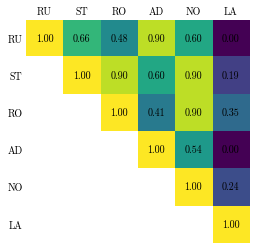

In [15]:
task_eval('5type')



Task: 4Type


Recall


Method: RandomUnder

Task: 4type.
Method: RandomUnder
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


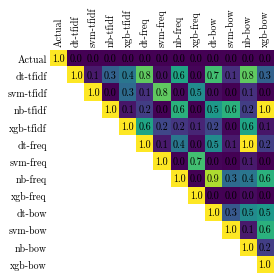

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
svm-bow    0.441176  0.125000  0.410256  0.308943    0.321344  0.314706
xgb-bow    0.364706  0.125000  0.435897  0.357724    0.320832  0.232353
nb-freq    0.494118  0.250000  0.358974  0.146341    0.312358  0.326471
nb-tfidf   0.482353  0.125000  0.358974  0.219512    0.296460  0.258824
nb-bow     0.382353  0.125000  0.461538  0.186992    0.288971  0.247059
dt-freq    0.376471  0.250000  0.282051  0.243902    0.288106  0.347059
dt-tfidf   0.441176  0.125000  0.333333  0.178862    0.269593  0.294118
xgb-tfidf  0.311765  0.125000  0.384615  0.252033    0.268353  0.382353
dt-bow     0.447059  0.000000  0.410256  0.195122    0.263109  0.364706
xgb-freq   0.247059  0.250000  0.282051  0.195122    0.243558  0.364706
svm-freq   0.282353  0.250000  0.230769  0.203252    0.241594  0.314706
svm-tfidf  0.329412  0.125000  0.358974  0.138211    0.237899  0

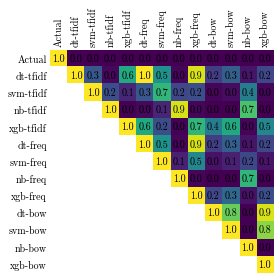

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.494118    0.500  0.589744  0.113821    0.424421  0.367647
dt-bow     0.594118    0.125  0.564103  0.365854    0.412268  0.400000
xgb-bow    0.558824    0.125  0.487179  0.430894    0.400474  0.444118
svm-bow    0.605882    0.125  0.410256  0.365854    0.376748  0.444118
svm-tfidf  0.464706    0.000  0.794872  0.211382    0.367740  0.494118
svm-freq   0.511765    0.000  0.666667  0.235772    0.353551  0.485294
xgb-freq   0.547059    0.000  0.538462  0.308943    0.348616  0.350000
dt-freq    0.552941    0.000  0.538462  0.292683    0.346021  0.417647
xgb-tfidf  0.570588    0.000  0.410256  0.365854    0.336675  0.464706
nb-freq    0.541176    0.375  0.282051  0.105691    0.325980  0.447059
nb-tfidf   0.523529    0.375  0.256410  0.146341    0.325320  0.497059
dt-tfidf   0.588235    0.000  0.435897  0.276423    0.325139  0.352941
Mean  

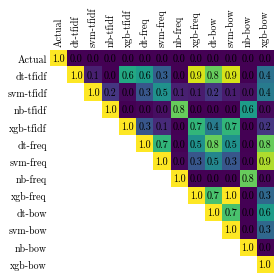

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
xgb-bow    0.529412  0.375000  0.589744  0.227642    0.430449  0.461765
dt-bow     0.564706  0.250000  0.589744  0.252033    0.414120  0.391176
svm-bow    0.611765  0.125000  0.666667  0.211382    0.403703  0.458824
svm-tfidf  0.441176  0.125000  0.846154  0.195122    0.401863  0.423529
svm-freq   0.529412  0.125000  0.615385  0.219512    0.372327  0.323529
xgb-tfidf  0.558824  0.000000  0.487179  0.398374    0.361094  0.335294
dt-tfidf   0.552941  0.000000  0.461538  0.357724    0.343051  0.479412
nb-bow     0.452941  0.500000  0.307692  0.105691    0.341581  0.311765
xgb-freq   0.547059  0.000000  0.333333  0.414634    0.323757  0.435294
nb-tfidf   0.494118  0.375000  0.282051  0.130081    0.320313  0.447059
nb-freq    0.494118  0.375000  0.307692  0.089431    0.316560  0.461765
dt-freq    0.529412  0.000000  0.333333  0.365854    0.307150  0

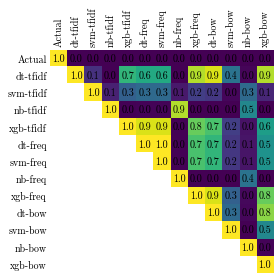

            Score 0  Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000    1.000  1.000000  1.000000    1.000000  1.000000
nb-bow     0.476471    0.500  0.794872  0.113821    0.471291  0.485294
xgb-bow    0.647059    0.125  0.282051  0.349593    0.350926  0.458824
dt-bow     0.670588    0.125  0.256410  0.300813    0.338203  0.352941
nb-tfidf   0.529412    0.375  0.307692  0.121951    0.333514  0.382353
nb-freq    0.535294    0.375  0.307692  0.097561    0.328887  0.514706
svm-bow    0.735294    0.125  0.025641  0.390244    0.319045  0.479412
dt-tfidf   0.682353    0.000  0.256410  0.300813    0.309894  0.420588
xgb-freq   0.647059    0.000  0.230769  0.341463    0.304823  0.458824
dt-freq    0.623529    0.000  0.256410  0.325203    0.301286  0.473529
xgb-tfidf  0.641176    0.000  0.205128  0.325203    0.292877  0.347059
svm-freq   0.664706    0.000  0.000000  0.349593    0.253575  0.461765
svm-tfidf  0.564706    0.000  0.000000  0.382114    0.236705  0.476471
Mean  

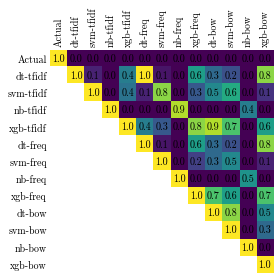

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.729412  0.125000  0.384615  0.317073    0.389025  0.520588
nb-bow     0.458824  0.500000  0.307692  0.105691    0.343052  0.497059
xgb-tfidf  0.705882  0.000000  0.256410  0.382114    0.336102  0.564706
nb-tfidf   0.517647  0.375000  0.307692  0.121951    0.330573  0.314706
xgb-freq   0.711765  0.000000  0.256410  0.349593    0.329442  0.488235
xgb-bow    0.670588  0.000000  0.282051  0.357724    0.327591  0.526471
nb-freq    0.523529  0.375000  0.307692  0.097561    0.325946  0.535294
dt-tfidf   0.688235  0.000000  0.256410  0.317073    0.315430  0.511765
svm-freq   0.829412  0.000000  0.000000  0.414634    0.311011  0.488235
dt-freq    0.694118  0.000000  0.230769  0.317073    0.310490  0.341176
svm-tfidf  0.800000  0.000000  0.000000  0.430894    0.307724  0.555882
svm-bow    0.758824  0.000000  0.025641  0.422764    0.301807  0

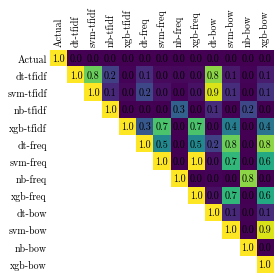

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
xgb-tfidf  0.658824  0.500000  0.512821  0.479675    0.537830  0.479412
dt-freq    0.547059  0.500000  0.589744  0.487805    0.531152  0.373529
dt-bow     0.441176  0.500000  0.615385  0.479675    0.509059  0.476471
dt-tfidf   0.511765  0.500000  0.615385  0.357724    0.496218  0.558824
xgb-freq   0.629412  0.250000  0.487179  0.504065    0.467664  0.414706
xgb-bow    0.588235  0.250000  0.410256  0.528455    0.444237  0.529412
svm-freq   0.729412  0.000000  0.615385  0.341463    0.421565  0.467647
svm-bow    0.629412  0.125000  0.384615  0.495935    0.408741  0.573529
svm-tfidf  0.558824  0.000000  0.538462  0.382114    0.369850  0.558824
nb-tfidf   0.417647  0.125000  0.410256  0.430894    0.345949  0.541176
nb-freq    0.394118  0.125000  0.538462  0.308943    0.341631  0.364706
nb-bow     0.294118  0.125000  0.410256  0.463415    0.323197  0

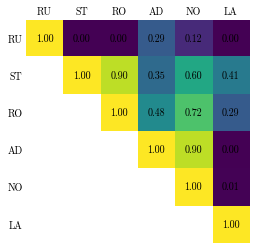

Precision


Method: RandomUnder

Task: 4type.
Method: RandomUnder
Cochran's Q test p-value: 5.684879652185987e-309
Post-hoc Dunn test array:


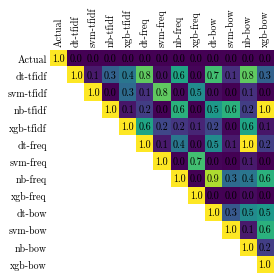

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.760000  0.000000  0.258065  0.393443    0.352877  0.258824
xgb-bow    0.729412  0.014085  0.223684  0.407407    0.343647  0.364706
svm-bow    0.728155  0.015385  0.228571  0.372549    0.336165  0.294118
nb-bow     0.706522  0.010204  0.214286  0.348485    0.319874  0.314706
nb-freq    0.700000  0.021053  0.205882  0.315789    0.310681  0.247059
svm-freq   0.761905  0.017857  0.101124  0.328947    0.302458  0.326471
nb-tfidf   0.666667  0.019231  0.157303  0.355263    0.299616  0.347059
dt-freq    0.640000  0.033898  0.114583  0.352941    0.285356  0.232353
xgb-tfidf  0.535354  0.017857  0.141509  0.392405    0.271781  0.314706
dt-tfidf   0.585938  0.018868  0.141304  0.328358    0.268617  0.341176
svm-tfidf  0.543689  0.013699  0.123894  0.333333    0.253654  0.382353
xgb-freq   0.482759  0.029851  0.115789  0.263736    0.223034  0

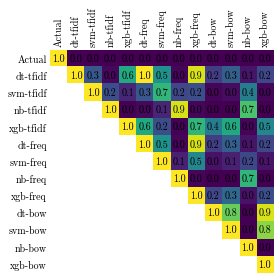

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.696552  0.035714  0.305556  0.473684    0.377876  0.444118
xgb-bow    0.693431  0.041667  0.327586  0.438017    0.375175  0.350000
nb-tfidf   0.760684  0.022059  0.217391  0.439024    0.359790  0.444118
svm-tfidf  0.731481  0.000000  0.221429  0.481481    0.358598  0.464706
svm-bow    0.695946  0.045455  0.285714  0.394737    0.355463  0.417647
nb-freq    0.747967  0.022388  0.234043  0.361111    0.341377  0.400000
svm-freq   0.690476  0.000000  0.245283  0.420290    0.339012  0.447059
nb-bow     0.736842  0.044444  0.252747  0.311111    0.336286  0.352941
dt-freq    0.676259  0.000000  0.228261  0.428571    0.333273  0.485294
xgb-tfidf  0.683099  0.000000  0.210526  0.432692    0.331579  0.497059
xgb-freq   0.673913  0.000000  0.244186  0.400000    0.329525  0.367647
dt-tfidf   0.645161  0.000000  0.217949  0.395349    0.314615  0

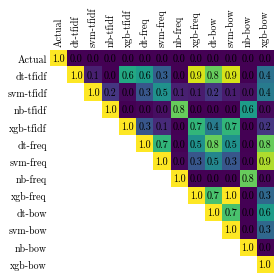

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1.000000
dt-bow     0.716418  0.027397  0.328571  0.492063    0.391113  0.435294
svm-bow    0.722222  0.017241  0.313253  0.472727    0.381361  0.479412
xgb-bow    0.652174  0.042857  0.348485  0.424242    0.366940  0.423529
svm-tfidf  0.714286  0.027027  0.224490  0.470588    0.359098  0.417647
nb-bow     0.793814  0.025806  0.218182  0.393939    0.357936  0.458824
nb-tfidf   0.756757  0.021277  0.224490  0.410256    0.353195  0.391176
xgb-tfidf  0.683453  0.000000  0.243590  0.449541    0.344146  0.447059
svm-freq   0.708661  0.025641  0.226415  0.397059    0.339444  0.323529
xgb-freq   0.699248  0.000000  0.200000  0.432203    0.332863  0.461765
nb-freq    0.750000  0.021429  0.222222  0.323529    0.329295  0.335294
dt-tfidf   0.657343  0.000000  0.230769  0.415094    0.325802  0.311765
dt-freq    0.661765  0.000000  0.209677  0.398230    0.317418  0

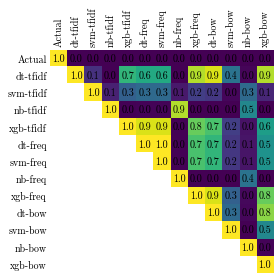

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000  1.000000       1.0  1.000000    1.000000  1.000000
nb-bow     0.794118  0.044944  0.274336  0.388889    0.375572  0.479412
svm-freq   0.620879  0.000000      None  0.494253    0.371711  0.473529
svm-tfidf  0.631579  0.000000      None  0.479592    0.370390  0.458824
xgb-bow    0.621469  0.035714   0.37931  0.405660    0.360538  0.347059
nb-tfidf   0.743802  0.022388      0.24  0.428571    0.358690  0.352941
nb-freq    0.745902  0.022388  0.230769  0.375000    0.343515  0.420588
svm-bow    0.637755  0.043478      0.25  0.410256    0.335372  0.461765
dt-tfidf   0.588832  0.000000  0.285714  0.440476    0.328756  0.382353
dt-bow     0.636872  0.038462      0.25  0.389474    0.328702  0.458824
xgb-freq   0.594595  0.000000  0.257143  0.407767    0.314876  0.514706
dt-freq    0.572973  0.000000   0.25641  0.430108    0.314873  0.485294
xgb-tfidf  0.595628  0.000000  0.235294  0.392157    0.305770  0

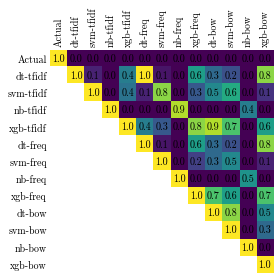

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000       1.0       1.0  1.000000    1.000000  1.000000
svm-freq   0.607759      None      None  0.472222    0.539990  0.341176
svm-bow    0.626214      None  0.333333  0.396947    0.452164  0.520588
dt-bow     0.616915      0.25  0.333333  0.433333    0.408396  0.488235
nb-tfidf   0.765217  0.021277  0.244898  0.428571    0.364991  0.555882
nb-bow     0.795918  0.025806  0.218182  0.406250    0.361539  0.488235
svm-tfidf  0.596491       0.0      None  0.481818    0.359436  0.535294
nb-freq    0.754237  0.021583  0.235294  0.375000    0.346529  0.347059
xgb-tfidf  0.612245       0.0  0.277778  0.456311    0.336583  0.564706
xgb-bow    0.600000       0.0   0.34375  0.382609    0.331590  0.526471
xgb-freq   0.605000       0.0  0.277778  0.425743    0.327130  0.511765
dt-tfidf   0.593909       0.0  0.238095  0.423913    0.313979  0.314706
dt-freq    0.592965       0.0      0.25  0.406250    0.312304  0

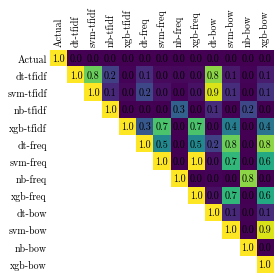

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
Actual     1.000000       1.0  1.000000  1.000000    1.000000  1.000000
xgb-tfidf  0.629213  0.307692  0.555556  0.522124    0.503646  0.373529
xgb-freq   0.648485  0.181818  0.487179  0.496000    0.453371  0.414706
svm-tfidf  0.575758      None  0.283784  0.465347    0.441629  0.364706
dt-freq    0.636986  0.190476  0.365079  0.545455    0.434499  0.558824
xgb-bow    0.666667  0.105263  0.421053  0.488722    0.420426  0.479412
svm-bow    0.644578     0.125  0.441176  0.462121    0.418219  0.573529
dt-bow     0.609756  0.210526  0.369231  0.443609    0.408281  0.541176
dt-tfidf   0.621429  0.166667  0.279070  0.488889    0.389013  0.558824
svm-freq   0.642487       0.0  0.413793  0.477273    0.383388  0.529412
nb-tfidf   0.669811  0.014085  0.313725  0.473214    0.367709  0.467647
nb-bow     0.531915  0.017544  0.470588  0.367742    0.346947  0.538235
nb-freq    0.620370  0.013889  0.368421  0.368932    0.342903  0

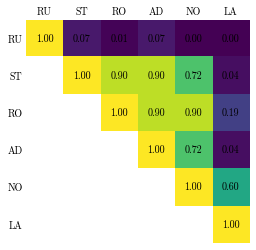



F1


Task: 4type.
Method: RandomUnder
Cochran's Q test p-value: 9.306587358262415e-16
Post-hoc Dunn test array:


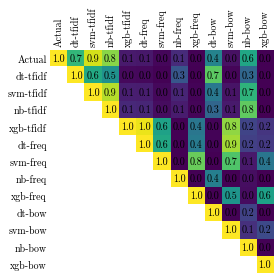

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
dt-bow     0.562963       NaN  0.316832  0.260870    0.301452  0.302775
dt-freq    0.474074  0.059701  0.162963  0.288462    0.286724  0.278352
dt-tfidf   0.503356  0.032787  0.198473  0.231579    0.269104  0.315904
nb-bow     0.496183  0.018868  0.292683  0.243386    0.303638  0.276809
nb-freq    0.579310  0.038835  0.261682  0.200000    0.311517  0.281267
nb-tfidf   0.559727  0.033333  0.218750  0.271357    0.298030  0.296516
svm-bow    0.549451  0.027397  0.293578  0.337778    0.328588  0.304064
svm-freq   0.412017  0.033333  0.140625  0.251256    0.268621  0.320480
svm-tfidf  0.410256  0.024691  0.184211  0.195402    0.245524  0.360593
xgb-bow    0.486275  0.025316  0.295652  0.380952    0.331848  0.283860
xgb-freq   0.326848  0.053333  0.164179  0.224299    0.232844  0.364706
xgb-tfidf  0.394052  0.031250  0.206897  0.306931    0.270056  0.345247
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1

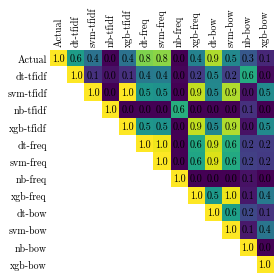

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
dt-bow     0.641270  0.055556  0.396396  0.412844    0.394324  0.420906
dt-freq    0.608414       NaN  0.320611  0.347826    0.339527  0.448937
dt-tfidf   0.615385       NaN  0.290598  0.325359    0.319790  0.411765
nb-bow     0.591549  0.081633  0.353846  0.166667    0.375248  0.360144
nb-freq    0.627986  0.042254  0.255814  0.163522    0.333501  0.422222
nb-tfidf   0.620209  0.041667  0.235294  0.219512    0.341688  0.469099
svm-bow    0.647799  0.066667  0.336842  0.379747    0.365796  0.430476
svm-freq   0.587838       NaN  0.358621  0.302083    0.346129  0.465392
svm-tfidf  0.568345       NaN  0.346369  0.293785    0.363111  0.478961
xgb-bow    0.618893  0.062500  0.391753  0.434426    0.387412  0.391481
xgb-freq   0.603896       NaN  0.336000  0.348624    0.338802  0.358607
xgb-tfidf  0.621795       NaN  0.278261  0.396476    0.334108  0.480338
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1

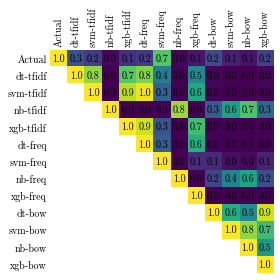

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
dt-bow     0.631579  0.049383  0.422018  0.333333    0.402288  0.412058
dt-freq    0.588235       NaN  0.257426  0.381356    0.312199  0.438599
dt-tfidf   0.600639       NaN  0.307692  0.384279    0.334204  0.377826
nb-bow     0.576779  0.049080  0.255319  0.166667    0.349567  0.371262
nb-freq    0.595745  0.040541  0.258065  0.140127    0.322802  0.388496
nb-tfidf   0.597865  0.040268  0.250000  0.197531    0.335951  0.417255
svm-bow    0.662420  0.030303  0.426230  0.292135    0.392214  0.468892
svm-freq   0.606061  0.042553  0.331034  0.282723    0.355126  0.323529
svm-tfidf  0.545455  0.044444  0.354839  0.275862    0.379279  0.420568
xgb-bow    0.584416  0.076923  0.438095  0.296296    0.396165  0.441821
xgb-freq   0.613861       NaN  0.250000  0.423237    0.328247  0.448139
xgb-tfidf  0.614887       NaN  0.324786  0.422414    0.352417  0.383193
Actual     1.000000  1.000000  1.000000  1.000000    1.000000  1

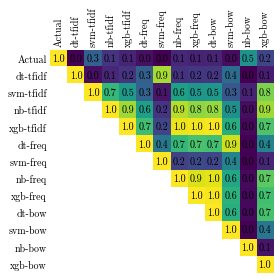

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
dt-bow     0.653295  0.058824  0.253165  0.339450    0.333385  0.398977
dt-freq    0.597183       NaN   0.25641  0.370370    0.307929  0.479340
dt-tfidf   0.632153       NaN   0.27027  0.357488    0.319046  0.400560
nb-bow     0.595588  0.082474  0.407895  0.176101    0.418022  0.482335
nb-freq    0.623288  0.042254  0.263736  0.154839    0.336042  0.462912
nb-tfidf   0.618557  0.042254  0.269663  0.189873    0.345644  0.367059
svm-bow    0.683060  0.064516  0.046512  0.400000    0.327005  0.470423
svm-freq   0.642045       NaN       NaN  0.409524    0.301483  0.467573
svm-tfidf  0.596273       NaN       NaN  0.425339    0.288829  0.467481
xgb-bow    0.634006  0.055556  0.323529  0.375546    0.355667  0.395191
xgb-freq   0.619718       NaN  0.243243  0.371681    0.309768  0.485161
xgb-tfidf  0.617564       NaN  0.219178  0.355556    0.299185  0.401597
Actual     1.000000  1.000000       1.0  1.000000    1.000000  1

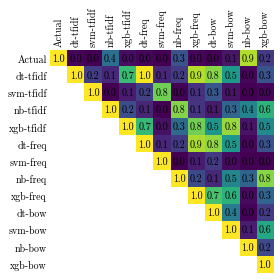

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
dt-bow     0.668464  0.166667  0.357143  0.366197    0.398475  0.503893
dt-freq    0.639566       NaN      0.24  0.356164    0.311394  0.404623
dt-tfidf   0.637602       NaN  0.246914  0.362791    0.314703  0.389743
nb-bow     0.582090   0.04908  0.255319  0.167742    0.352053  0.492608
nb-freq    0.618056  0.040816  0.266667  0.154839    0.335922  0.421098
nb-tfidf   0.617544  0.040268  0.272727  0.189873    0.346930  0.401888
svm-bow    0.686170       NaN  0.047619  0.409449    0.361994  0.416471
svm-freq   0.701493       NaN       NaN  0.441558    0.394695  0.401669
svm-tfidf  0.683417       NaN       NaN  0.454936    0.331576  0.545394
xgb-bow    0.633333       NaN  0.309859  0.369748    0.329578  0.526471
xgb-freq   0.654054       NaN  0.266667  0.383929    0.328282  0.499723
xgb-tfidf  0.655738       NaN  0.266667  0.415929    0.336342  0.564706
Actual     1.000000       1.0       1.0  1.000000    1.000000  1

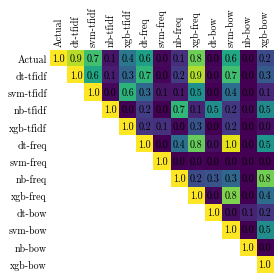

            Score 0   Score 1   Score 2   Score 3  Mean score  Accuracy
dt-bow     0.511945  0.296296  0.461538  0.460937    0.453134  0.506766
dt-freq    0.588608  0.275862  0.450980  0.515021    0.477988  0.447764
dt-tfidf   0.561290      0.25  0.384000  0.413146    0.436124  0.558824
nb-bow     0.378788  0.030769  0.438356  0.410072    0.334651  0.538235
nb-freq    0.482014     0.025  0.437500  0.336283    0.342266  0.413163
nb-tfidf   0.514493  0.025316  0.355556  0.451064    0.356497  0.501732
svm-bow    0.636905     0.125  0.410959  0.478431    0.413425  0.573529
svm-freq   0.683196       NaN  0.494845  0.398104    0.401571  0.496616
svm-tfidf  0.567164       NaN  0.371681  0.419643    0.402565  0.441364
xgb-bow    0.625000  0.148148  0.415584  0.507812    0.432004  0.503173
xgb-freq   0.638806  0.210526  0.487179  0.500000    0.460406  0.414706
xgb-tfidf  0.643678  0.380952  0.533333  0.500000    0.520177  0.419899
Actual     1.000000       1.0  1.000000  1.000000    1.000000  1

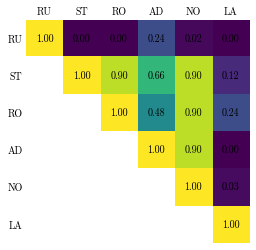

In [16]:
task_eval('4type')